<a href="https://colab.research.google.com/github/UrbanGISer/XGeoML/blob/main/XGeoML_1_Base_Models_GWR_MGWR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Explainable Geospatial Machine Learning Model-1 Base Models

Lingbo Liu

Center for Geographical Analysis

Harvard University

Lingboliu@fas.harvard.edu


**Part 1: Comparsion with GWR, MGWR**

## 0 Install packages

In [ ]:
!pip install libpysal  mgwr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 11.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.4/41.4 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 331.8/331.8 kB 33.3 MB/s eta 0:00:00


# 1 Create Synthetic Data

In [ ]:
import numpy as np
import pandas as pd
import math
# Grid setup (assuming these values are already defined)
grid_size = 30
u = np.repeat(np.arange(1, grid_size + 1), grid_size)
v = np.tile(np.arange(1, grid_size + 1), grid_size)

n=grid_size **2
np.random.seed(1234567)
x1 = np.random.normal(loc=0, scale=1, size=n)
x2 = np.random.normal(loc=0, scale=1, size=n)
x3 = np.random.normal(loc=0, scale=1, size=n)
x4 = np.random.normal(loc=0, scale=1, size=n)
x5 = np.random.normal(loc=0, scale=1, size=n)
x6 = np.random.normal(loc=0, scale=1, size=n)
epsilon = np.random.normal(loc=0, scale=0.5, size=n)


# 1-Degree for linear gradient
angle_degrees = 45
angle_radians = np.radians(angle_degrees)

# 1-Linear discrete band
n_bands = 10

# Calculate increase X Y
dx = np.cos(angle_radians)
dy = np.sin(angle_radians)

# Projection
X, Y = np.meshgrid(np.arange(grid_size), np.arange(grid_size))
projection = dx * X + dy * Y

# Normal [0, 1]
alpha1 = (projection - np.min(projection)) / (np.max(projection) - np.min(projection))
alpha2 = np.floor(alpha1 * n_bands) / n_bands

beta_linear= alpha1.flatten()
beta_lineardiscrete = alpha2.flatten()

# 2-Cosine
scale= 2
GS=grid_size/scale

beta_cos = 1 + 2 * (np.cos(math.pi * u / grid_size) * np.cos(math.pi * v / grid_size))
# beta_cos /= (beta_cos - np.min(beta_cos)) / (np.max(beta_cos) - np.min(beta_cos))
beta_cos_flat1 = beta_cos.flatten()


beta_cos = 1 + 2 * (np.cos(math.pi * u / GS) * np.cos(math.pi * v / GS))
# beta_cos /= (beta_cos - np.min(beta_cos)) / (np.max(beta_cos) - np.min(beta_cos))
beta_cos_flat2 = beta_cos.flatten()


# 3. Circular Gradient
radius_k=10
position_x=2
position_y=2

center_x, center_y = grid_size / position_x, grid_size / position_y  # center of the circle
radius = grid_size *radius_k  # radius of the circle
Y, X = np.ogrid[:grid_size, :grid_size]
dist_from_center = np.sqrt((X - center_x)**2 + (Y - center_y)**2)
alpha3 = np.clip(1 - dist_from_center / radius, 0, 1)


# alpha3 /= (alpha3 - np.min(alpha3)) / (np.max(alpha3) - np.min(alpha3))
beta_circular_flat = alpha3.flatten()

# 4. Kernel Density Gradient (alpha4) with manual kernels
# Random Generate
# n_points = 3
# kernel_s=3
# kernel_e=10
# kernel_radii = np.random.uniform(kernel_s, kernel_e, n_points)  # different kernel radii for each point
# points = np.vstack([np.random.uniform(0, grid_size, n_points), np.random.uniform(0, grid_size, n_points)])
kernel_radii = np.array([7, 3, 5 ])
points = np.array([[ 8,  10,  25],
       [11, 28, 4]])

# Initialize alpha4 grid
alpha4 = np.zeros((grid_size, grid_size))

# Apply a Gaussian kernel to each point and sum the results
for point, radius in zip(points.T, kernel_radii):
    Y, X = np.ogrid[:grid_size, :grid_size]
    dist_from_point = np.sqrt((X - point[0])**2 + (Y - point[1])**2)
    gaussian = np.exp(-(dist_from_point**2 / (2. * radius**2)))
    alpha4 += gaussian

# alpha4 /= (alpha4 - np.min(alpha4)) / (np.max(alpha4) - np.min(alpha4))
alpha4_flat = alpha4.flatten()


df = pd.DataFrame({
    'u': u,
    'v': v,
    'x1': x1,
    'x2': x2,
    'x3': x3,
    'x4': x4,
    'x5': x5,
    'x6': x6,
    'e': epsilon,
    'b_linear': beta_linear,
    'b_lineardiscrete': beta_lineardiscrete,
    'b_cos_basic': beta_cos_flat1,
    'b_cos_ad': beta_cos_flat2,
    'b_circular': beta_circular_flat,
    'b_poly': alpha4_flat,
})




In [ ]:
# 计算每列的最小值和最大值
min_values = df.min()
max_values = df.max()

# 定义缩放的目标范围
min_range = 0
max_range = 5

# 对每列进行 min-max 缩放
for column in ['b_linear','b_lineardiscrete','b_cos_basic','b_cos_ad','b_circular','b_poly']:
    df[column] = min_range + (df[column] - min_values[column]) * (max_range - min_range) / (max_values[column] - min_values[column])


In [ ]:
df['y'] = df['b_linear'] * df['x1'] + df['x2'] * df['b_circular'] + df['x3']**2 * df['b_cos_basic'] + df['x4']**3 * df['b_poly']+df['e']

In [ ]:
df.head(5)

,u,v,x1,x2,x3,x4,x5,x6,e,b_linear,b_lineardiscrete,b_cos_basic,b_cos_ad,b_circular,b_poly,y
0,1,1,-0.514625,0.688297,0.992160,0.620480,1.068074,1.142192,-0.054045,0.000000,0.0,4.972609,4.891932,0.000000,0.719144,5.012690
1,1,2,-0.449554,-0.391767,-0.556702,0.386716,-0.224860,0.788291,-0.623987,0.086207,0.0,4.931786,4.733956,0.163794,0.838430,0.850026
2,1,3,1.734621,-0.240266,0.449129,1.595730,0.474081,-0.279895,0.035431,0.172414,0.0,4.864244,4.478345,0.321444,0.957690,5.129849
3,1,4,0.643380,-0.070372,0.063307,0.408018,-0.153461,-1.031303,-0.281256,0.258621,0.0,4.770724,4.136271,0.472307,1.071801,-0.056179
4,1,5,0.026139,0.442559,1.255714,-1.568991,-0.745217,-0.004208,-0.458297,0.344828,0.0,4.652251,3.722685,0.615685,1.175354,2.619219


In [ ]:
df.to_csv("/content/df.csv")

isualization

In [ ]:
truebeta= ['b_linear','b_circular', 'b_cos_basic',  'b_poly']

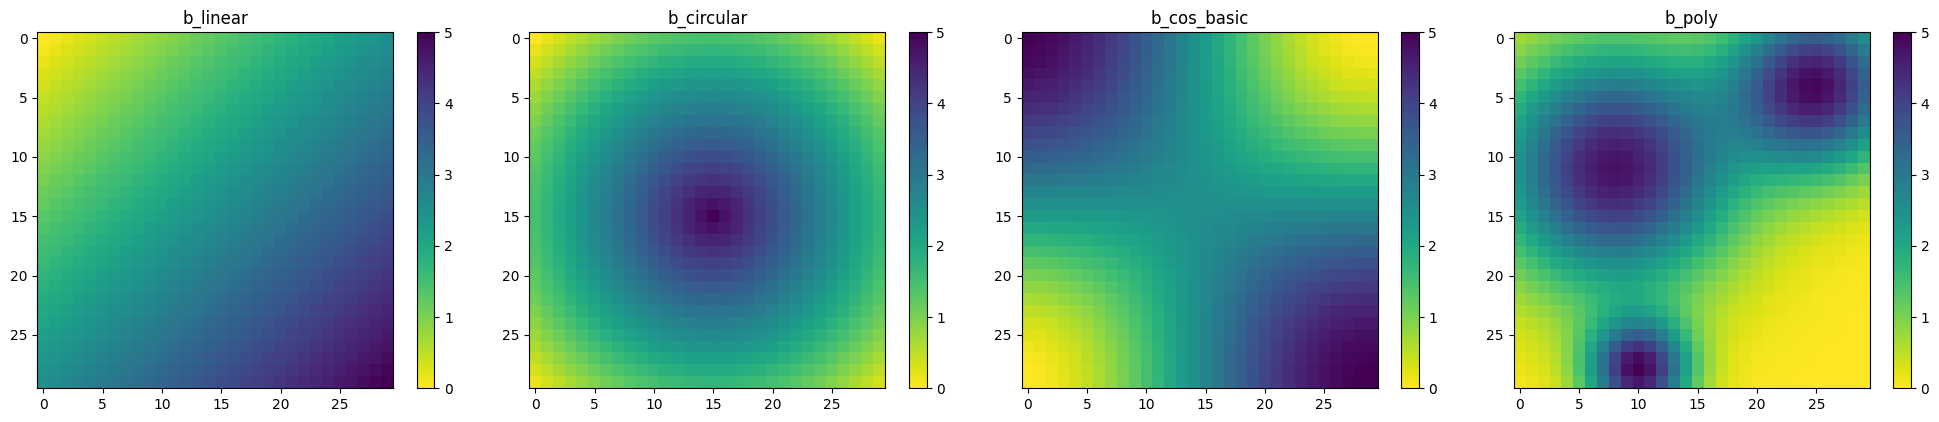

In [ ]:
import matplotlib.pyplot as plt

def plot_heatmap(ax, data, title):
    im = ax.imshow(data, cmap='viridis_r', interpolation='nearest',vmin=0, vmax=5)
    plt.colorbar(im, ax=ax,
                #  label='Value',
                 )
    # ax.set_xlabel('v')
    # ax.set_ylabel('u')
    ax.set_title(title)

# 创建画布
fig, axes = plt.subplots(1, 4, figsize=(20, 4))

# 数据和标题
data_list = [df.pivot(index='u', columns='v', values=i) for i in truebeta]
titles =truebeta

axes_flat = axes.flatten()


for idx, (ax, data, title) in enumerate(zip(axes_flat, data_list, titles)):
        plot_heatmap(ax, data, title)

# 调整子图布局

plt.tight_layout()
plt.show()


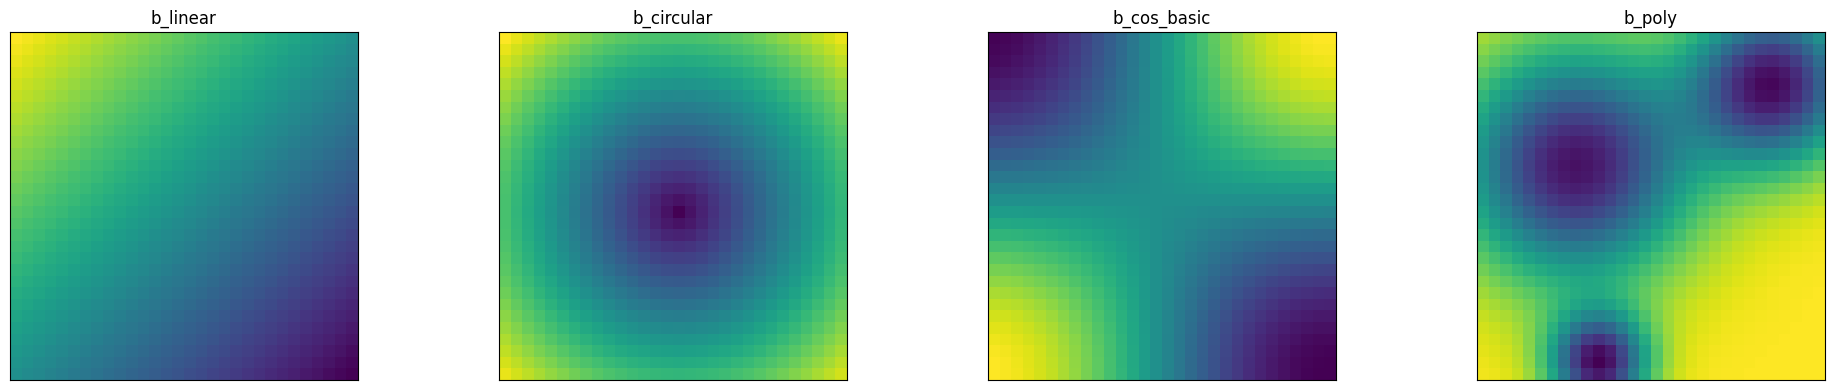

In [ ]:
import matplotlib.pyplot as plt

def plot_heatmap(ax, data, title):
    im = ax.imshow(data, cmap='viridis_r', interpolation='nearest', vmin=0, vmax=5)
    ax.set_title(title)
    # 移除x轴和y轴的刻度
    ax.set_xticks([])
    ax.set_yticks([])

# 创建画布
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
# 数据和标题
data_list = [df.pivot(index='u', columns='v', values=i) for i in truebeta]
titles = truebeta
axes_flat = axes.flatten()

for ax, data, title in zip(axes_flat, data_list, titles):
        plot_heatmap(ax, data, title)

# 调整子图布局
plt.tight_layout()
plt.show()


#2 GWR and MGWR


## 2-0 Install MGWR

## 2-1 Run GWR

In [ ]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

In [ ]:
#Prepare Georgia dataset inputs
g_y = df['y'].values.reshape((-1,1))
g_X = df[['x1', 'x2', 'x3','x4']].values
u = df['u']
v = df['v']
g_coords = list(zip(u,v))
# g_X = (g_X - g_X.mean(axis=0)) / g_X.std(axis=0)
g_y = g_y.reshape((-1,1))
# g_y = (g_y - g_y.mean(axis=0)) / g_y.std(axis=0)

In [ ]:
#Calibrate GWR model

gwr_selector = Sel_BW(g_coords, g_y, g_X)
gwr_bw = gwr_selector.search(bw_min=2)
print(gwr_bw)
gwr_results = GWR(g_coords, g_y, g_X, gwr_bw).fit()

57.0


In [ ]:
# gwr_results.params[0:5]

In [ ]:
# gwr_results.localR2[0:10]

In [ ]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 900
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          71885.071
Log-likelihood:                                                   -3248.238
AIC:                                                               6506.476
AICc:                                                              6508.570
BIC:                                                              65796.928
R2:                                                                   0.372
Adj. R2:                                                              0.370

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
gwrdf=pd.DataFrame(gwr_results.params,columns=['beta','b_linear','b_circular', 'b_cos_basic',  'b_poly'])

In [ ]:
gwrdf0=pd.concat([df[['u','v']],gwrdf], axis=1)

In [ ]:
targetname= ['b_linear','b_circular', 'b_cos_basic',  'b_poly']

## 2-2 GWR Visualization

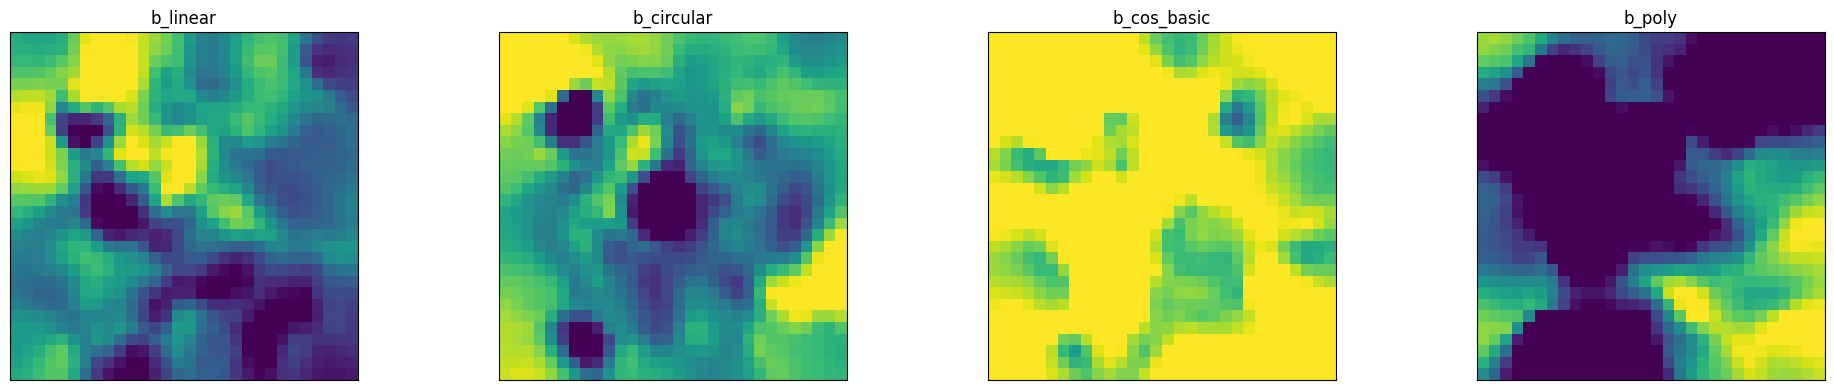

In [ ]:
import matplotlib.pyplot as plt

def plot_heatmap(ax, data, title):
    im = ax.imshow(data, cmap='viridis_r', interpolation='nearest', vmin=0, vmax=5)
    ax.set_title(title)
    # 移除x轴和y轴的刻度
    ax.set_xticks([])
    ax.set_yticks([])

# 创建画布
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
# 数据和标题
data_list = [gwrdf0.pivot(index='u', columns='v', values=i) for i in targetname]
titles = targetname
axes_flat = axes.flatten()

for ax, data, title in zip(axes_flat, data_list, titles):
        plot_heatmap(ax, data, title)

# 调整子图布局
plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import linregress

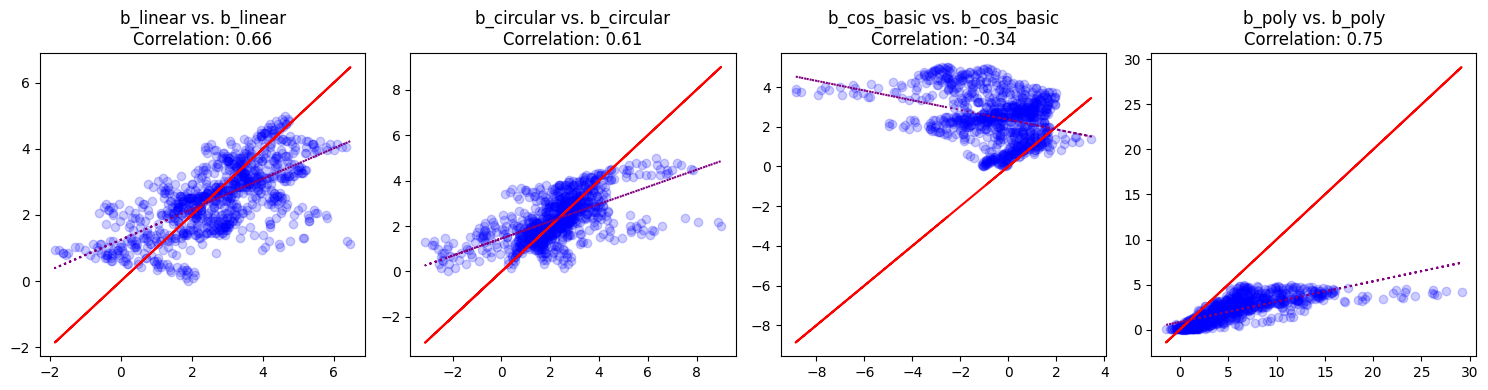

In [ ]:
# 设置图形大小
fig, axes = plt.subplots(1, 4, figsize=(15, 4))  # 2行4列

# 假设 feature_importances_df 共有8列，且 targetname 有4个元素
for idx, ax in enumerate(axes.flatten()):
    # 修正：为了在第二行使用不同的列，我们直接使用 idx 来引用列
    feature_column = targetname[idx]
    b_column = targetname[idx % 4]  # 使用整除来确保每行对应相同的b_column

    # 获取数据
    y = df[feature_column]
    x = gwrdf0[b_column]

    # 计算相关系数
    correlation = np.corrcoef(x, y)[0, 1]

    # 进行线性回归拟合
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # 绘制散点图
    ax.scatter(x, y, color='blue',alpha=0.2, label='Data Points')

    # 绘制拟合直线
    ax.plot(x,  x , color='red', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
    ax.plot(x, slope * x + intercept, color='purple',ls='dotted', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
    # 添加标题、图例和相关系数
    ax.set_title(f'{feature_column} vs. {b_column}\nCorrelation: {correlation:.2f}')
    #ax.legend()
    #ax.grid(True)

# 调整布局
plt.tight_layout()
plt.show()

## 2-3 Run MGWR

In [ ]:
from mgwr.sel_bw import Sel_BW
from mgwr.gwr import GWR, MGWR
import pandas as pd
import libpysal as ps

In [ ]:
y = df['y'].values.reshape((-1,1))
X = df[['x1', 'x2', 'x3','x4']].values
coords = list(zip(df['u'], df['v']))

In [ ]:
selector = Sel_BW(coords, y, X, multi=True, constant=True)
bw = selector.search(multi_bw_min=[2], multi_bw_max=[159])
print('bw(intercept):', bw[0])
print('bw(foreign):', bw[1])
print('bw(african_amer):', bw[2])
print('bw(rural):', bw[3])
mgwr = MGWR(coords, y, X, selector, constant=True)
mgwr_results = mgwr.fit()
print('aicc:', mgwr_results.aicc)
print('sigma2:', mgwr_results.sigma2)
print('ENP(model):', mgwr_results.ENP)
print('adj_alpha(model):', mgwr_results.adj_alpha[1])
print('critical_t(model):', mgwr_results.critical_tval(alpha=mgwr_results.adj_alpha[1]))
alphas = mgwr_results.adj_alpha_j[:,1]
critical_ts = mgwr_results.critical_tval()
print('ENP(intercept):', mgwr_results.ENP_j[0])
print('adj_alpha(intercept):', alphas[0])
print('critical_t(intercept):', critical_ts[0])
print('ENP(foreign):', mgwr_results.ENP_j[1])
print('adj_alpha(foreign):', alphas[1])
print('critical_t(foreign):', critical_ts[1])
print('ENP(african_amer):', mgwr_results.ENP_j[2])
print('adj_alpha(african_amer):', alphas[2])
print('critical_t(african_amer):', critical_ts[2])
print('ENP(rural):', mgwr_results.ENP_j[3])
print('adj_alpha(rural):', alphas[3])
print('critical_t(rural):', critical_ts[3])

Backfitting:   0%|          | 0/200 [00:00<?, ?it/s]

bw(intercept): 154.0
bw(foreign): 136.0
bw(african_amer): 76.0
bw(rural): 23.0


Inference:   0%|          | 0/1 [00:00<?, ?it/s]

aicc: 5919.9634601466005
sigma2: 24.411090841326477
ENP(model): 282.60742753102875
adj_alpha(model): 0.000884619354077491
critical_t(model): 3.336042944954718
ENP(intercept): 13.840260955541819
adj_alpha(intercept): 0.003612648645904278
critical_t(intercept): 2.9178233678590226
ENP(foreign): 15.892934704871749
adj_alpha(foreign): 0.003146052062031893
critical_t(foreign): 2.9610977166165395
ENP(african_amer): 28.281985167307077
adj_alpha(african_amer): 0.0017679098445252755
critical_t(african_amer): 3.136077562647015
ENP(rural): 87.99412884504433
adj_alpha(rural): 0.0005682197284781224
critical_t(rural): 3.4587286391234615


In [ ]:
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 900
Number of covariates:                                                     5

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                          71885.071
Log-likelihood:                                                   -3248.238
AIC:                                                               6506.476
AICc:                                                              6508.570
BIC:                                                              65796.928
R2:                                                                   0.372
Adj. R2:                                                              0.370

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

## 2-4 MGWR Visualize

In [ ]:
mgwrdf=pd.DataFrame(mgwr_results.params,columns=['beta','b_linear','b_circular', 'b_cos_basic',  'b_poly'])

In [ ]:
mgwrdf1=pd.concat([df[['u','v']],mgwrdf], axis=1)

In [ ]:
targetname= ['b_linear','b_circular', 'b_cos_basic',  'b_poly']

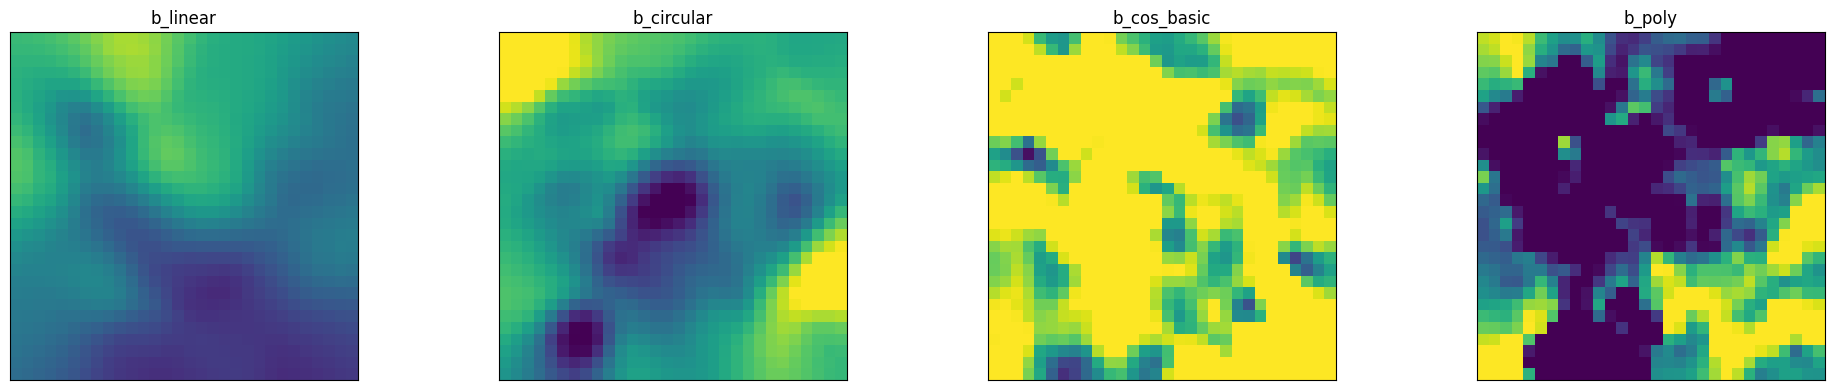

In [ ]:
import matplotlib.pyplot as plt

def plot_heatmap(ax, data, title):
    im = ax.imshow(data, cmap='viridis_r', interpolation='nearest', vmin=0, vmax=5)
    ax.set_title(title)
    # 移除x轴和y轴的刻度
    ax.set_xticks([])
    ax.set_yticks([])

# 创建画布
fig, axes = plt.subplots(1, 4, figsize=(20, 4))
# 数据和标题
data_list = [mgwrdf1.pivot(index='u', columns='v', values=i) for i in targetname]
titles = targetname
axes_flat = axes.flatten()

for ax, data, title in zip(axes_flat, data_list, titles):
        plot_heatmap(ax, data, title)

# 调整子图布局
plt.tight_layout()
plt.show()


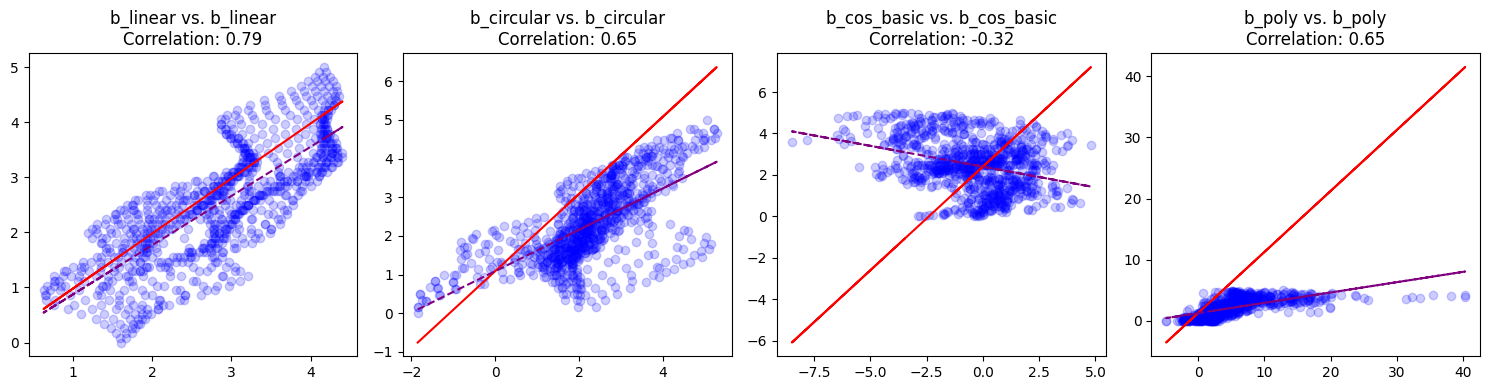

In [ ]:
# 设置图形大小
fig, axes = plt.subplots(1, 4, figsize=(15, 4))  # 2行4列

# 假设 feature_importances_df 共有8列，且 targetname 有4个元素
for idx, ax in enumerate(axes.flatten()):
    # 修正：为了在第二行使用不同的列，我们直接使用 idx 来引用列
    feature_column = targetname[idx]
    b_column = targetname[idx % 4]  # 使用整除来确保每行对应相同的b_column

    # 获取数据
    y = df[feature_column]
    x = mgwrdf1[b_column]

    # 计算相关系数
    correlation = np.corrcoef(x, y)[0, 1]

    # 进行线性回归拟合
    slope, intercept, r_value, p_value, std_err = linregress(x, y)

    # 绘制散点图
    ax.scatter(x, y, color='blue',alpha=0.2, label='Data Points')

    # 绘制拟合直线
    ax.plot(x,  x + intercept, color='red', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
    ax.plot(x, slope * x + intercept, color='purple',ls='--', label=f'Fit Line\ny={slope:.2f}x+{intercept:.2f}')
    # 添加标题、图例和相关系数
    ax.set_title(f'{feature_column} vs. {b_column}\nCorrelation: {correlation:.2f}')
    #ax.legend()
    #ax.grid(True)

# 调整布局
plt.tight_layout()
plt.show()